# MDF Single model learning by substances and quantities

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from prepare_data import PROCESSED_BIG, PROCESSED_SUBSTANCES, PROCESSED_VOIE_ADMIN, TARGET_COLUMNS, TRAIN, TEST, SOURCE

-- get_unique_noconst --
- Number of found duplicated rows :  1389
- Remove constant columns :  (10846, 41) -> (10846, 41)
- Dropped const columns :  


In [3]:
PROCESSED_TRAIN = PROCESSED_BIG[PROCESSED_BIG[SOURCE] == TRAIN].drop(SOURCE, axis=1)
PROCESSED_TRAIN_SUBS = PROCESSED_SUBSTANCES[PROCESSED_SUBSTANCES[SOURCE] == TRAIN].drop(SOURCE, axis=1)
PROCESSED_TRAIN_VOIE_ADMIN = PROCESSED_VOIE_ADMIN[PROCESSED_VOIE_ADMIN[SOURCE] == TRAIN].drop(SOURCE, axis=1)

In [4]:
print PROCESSED_TRAIN.shape, PROCESSED_TRAIN_SUBS.shape, PROCESSED_TRAIN_VOIE_ADMIN.shape

(7400, 39) (7400, 1767) (7400, 45)


In [5]:
PROCESSED_TRAIN.columns.values

array([u'agrement col', u'date amm annee', u'date declar annee',
       u'etat commerc', u'forme pharma', u'libelle_ampoule',
       u'libelle_capsule', u'libelle_comprime', u'libelle_film',
       u'libelle_flacon', u'libelle_gelule', u'libelle_pilulier',
       u'libelle_plaquette', u'libelle_poche', u'libelle_sachet',
       u'libelle_seringue', u'libelle_stylo', u'libelle_tube',
       u'nb_ampoule', u'nb_capsule', u'nb_comprime', u'nb_film',
       u'nb_flacon', u'nb_gelule', u'nb_ml', u'nb_pilulier',
       u'nb_plaquette', u'nb_poche', u'nb_sachet', u'nb_seringue',
       u'nb_stylo', u'nb_tube', u'prix', u'statut', u'statut admin',
       u'titulaires', u'tx rembours', u'type proc', 'logprix'], dtype=object)

In [6]:
PROCESSED_VOIE_ADMIN.columns.values

array([u'auriculaire', u'buccogingivale', u'cutan\xe9e', u'dentaire',
       u'endocanalaire', u'endosinusale', u'endotrach\xe9obronchique',
       u'gastrique', u'gastro-ent\xe9rale', u'gingivale', u'infiltration',
       u'inhal\xe9e', u'intra cholangio-pancr\xe9atique',
       u'intra-articulaire', u'intra-art\xe9rielle', u'intra-murale',
       u'intra-ut\xe9rine', u'intracaverneuse', u'intradermique',
       u'intradurale', u'intral\xe9sionnelle', u'intramusculaire',
       u'intrap\xe9riton\xe9ale', u'intras\xe9reuse', u'intrath\xe9cale',
       u'intraveineuse', u'intraventriculaire c\xe9r\xe9brale',
       u'intravitr\xe9enne', u'intrav\xe9sicale', u'nasale',
       u'ophtalmique', u'orale', u'p\xe9riarticulaire', u'p\xe9ridurale',
       u'p\xe9rineurale', u'p\xe9rioculaire', u'rectale',
       u'sous-cutan\xe9e', u'sublinguale', u'transdermique',
       u'ur\xe9trale', u'vaginale', u'voie buccale autre',
       u'voie extracorporelle autre', u'voie parent\xe9rale autre',
    

In [7]:
PROCESSED_SUBSTANCES.columns.values

array([ u' - A/CALIFORNIA/7/2009 A/CALIFORNIA/7/2009 ANALOGUE ANTIGENES GRIPPE H1N1PDM09 SOUCHE SOUCHE SURFACE VIRUS X-181',
       u' - A/CALIFORNIA/7/2009 A/CALIFORNIA/7/2009 ANALOGUE FRAGMENTE GRIPPE H1N1PDM09 INACTIVE NYMC SOUCHE SOUCHE VIRUS X-179A',
       u' - A/CALIFORNIA/7/2009 A/CHRISTCHURCH/16/2010 ANALOGUE FRAGMENTE GRIPPE H1N1 INACTIVE NIB-74XP PDM09 SOUCHE SOUCHE VIRUS',
       ..., u'ZUCLOPENTHIXOLCANOATE', '_ENCODED_', 'source'], dtype=object)

## Metric MAPE

In [8]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred, **kwards): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Learn by medecin types, substances and its quantities

In [88]:
types = [u'nb_capsule', u'nb_comprime',  u'nb_gelule', u'nb_ml', u'nb_sachet', u'nb_flacon']
packages = [u'nb_ampoule', u'nb_film', u'nb_flacon', u'nb_pilulier', u'nb_plaquette', u'nb_poche', u'nb_seringue', u'nb_stylo', u'nb_tube']
types_and_packages = list(types)
types_and_packages.extend(packages)

In [9]:
df = PROCESSED_TRAIN
df_subs = PROCESSED_TRAIN_SUBS.drop(['_ENCODED_'], axis=1)

In [10]:
from common.preprocessing_helper import drop_const_cols

def create_df_subs_quants(df_subs, series_quants):
    cols = df_subs.columns
    df_subs_quants = pd.DataFrame(columns=cols)
    for c in cols:
        df_subs_quants[c] = df_subs[c] * series_quants
    return df_subs_quants

### Learn by type : 'capsule'

In [11]:
index = 0
print "Select type only : ", types[index]
mask = df[types[index]] > 0
print "Found lines (med has the type): ", len(df[mask])
indices = range(len(types))
indices.remove(index)
for i in indices:
    mask &= df[types[i]] < 1
    
print "Found lines (med has the type only) : ", len(df[mask])
df_prices = df[mask]['logprix']

Select type only :  nb_capsule
Found lines (med has the type):  46
Found lines (med has the type only) :  46


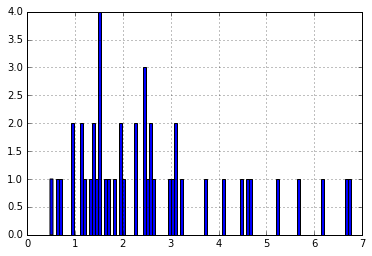

In [13]:
df_prices.hist(bins=100)

In [14]:
df_subs_quants = create_df_subs_quants(df_subs[mask], df[mask][types[index]])
print df_subs_quants.shape

(46, 1766)


#### Add packages

In [15]:
df_subs_quants_packs = pd.concat([df_subs_quants, df[mask][packages]], axis=1)
print df_subs_quants_packs.shape

(46, 1776)


#### Add other features 

In [16]:
cols_to_drop = list(types); cols_to_drop.extend(packages); cols_to_drop.extend(TARGET_COLUMNS)
cols_to_drop.extend([u'libelle_ampoule', u'libelle_capsule', u'libelle_comprime', u'libelle_film', u'libelle_flacon', u'libelle_gelule', u'libelle_pilulier', u'libelle_plaquette', u'libelle_poche', u'libelle_sachet', u'libelle_seringue', u'libelle_stylo', u'libelle_tube'])
other_features = df.drop(cols_to_drop, axis=1)
df_subs_quants_others = pd.concat([df_subs_quants_packs, other_features[mask]], axis=1)
print df_subs_quants_others.shape

(46, 1786)


#### Add voie admin

In [17]:
df_subs_quants_packs_va = pd.concat([df_subs_quants_packs, PROCESSED_TRAIN_VOIE_ADMIN[mask]], axis=1)
print df_subs_quants_packs_va.shape

(46, 1821)


#### Remove all zero columns

In [18]:
df_subs_quants = drop_const_cols(df_subs_quants)
df_subs_quants_packs = drop_const_cols(df_subs_quants_packs)
df_subs_quants_others = drop_const_cols(df_subs_quants_others)
df_subs_quants_packs_va = drop_const_cols(df_subs_quants_packs_va)

print "df_subs_quants -> ", df_subs_quants.shape
print "df_subs_quants_packs -> ", df_subs_quants_packs.shape
print "df_subs_quants_others -> ", df_subs_quants_others.shape
print "df_subs_quants_packs_va -> ", df_subs_quants_packs_va.shape
# print "- Remove constant columns : ", df_subs_quants_others.shape, '->', res.shape
# print "- Dropped const columns : ", 
# if len(df_subs_quants_others.columns) > len(res.columns):
#     print df_subs_quants_others.columns.difference(res.columns).values
# print ""
# df_subs_quants_others = res
# del res

df_subs_quants ->  (46, 22)
df_subs_quants_packs ->  (46, 25)
df_subs_quants_others ->  (46, 34)
df_subs_quants_packs_va ->  (46, 27)


#### Split and learn

In [20]:
y = df_prices
X = StandardScaler().fit_transform(df_subs_quants)
XX = StandardScaler().fit_transform(df_subs_quants_packs_va)

X_train, X_test, XX_train, XX_test, y_train, y_test = train_test_split(X, XX, y, train_size=0.75)

In [21]:
rf = RandomForestRegressor(n_estimators = 35, n_jobs = -1, verbose = 0)

In [22]:
rf.fit(X_train, y_train)
score = rf.score(X_train, y_train)
print score
res0 = rf.predict(X_train)
res1 = rf.predict(X_test)
print mape_error(y_train, res0)
print mape_error(y_test, res1)

rf.fit(XX_train, y_train)
score = rf.score(XX_train, y_train)
print score
res01 = rf.predict(XX_train)
res11 = rf.predict(XX_test)
print mape_error(y_train, res01)
print mape_error(y_test, res11)


print res1[:10]
print res11[:10]
print y_test.values[:10]

0.845274547088
19.3195297181
42.6397809023
0.8559892565
20.71265451
44.3137529296
[ 1.1817625   1.61630301  1.1817625   2.4523484   2.76003835  2.81336815
  2.76003835  1.61630301  1.80585173  1.80585173]
[ 1.19114698  1.91967433  1.19114698  2.29401976  2.8482254   2.72067537
  2.72867668  1.61241544  1.9392601   1.9392601 ]
[ 0.93216408  1.49514877  2.02683159  1.65441128  2.48490665  1.95444505
  2.59450816  1.37876609  2.30058309  6.77745295]


In [23]:
X0 = df_subs_quants_packs_va
y = df_prices

X = StandardScaler().fit_transform(X0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [24]:
rf = RandomForestRegressor(n_estimators = 35, n_jobs = -1, verbose = 0)

In [25]:
rf.fit(X_train, y_train)
score = rf.score(X_train, y_train)
print score
res0 = rf.predict(X_train)
res1 = rf.predict(X_test)
print mape_error(y_train, res0)
print mape_error(y_test, res1)
print res1[:10]
print y_test.values[:10]

0.859592892678
18.3542238593
53.9691290195
[ 1.44695951  2.49752719  1.52140662  2.38257469  1.76418749  1.76418749
  1.44695951  1.74946681  1.52140662  1.76418749]
[ 1.47247206  2.59450816  2.48490665  2.48490665  0.63657683  0.47623418
  1.19088756  3.10279135  1.49514877  4.49880917]


In [26]:
svr = SVR(kernel='linear', C=3)
svr.fit(X_train, y_train)
score = svr.score(X_train, y_train)
print score
res0 = svr.predict(X_train)
res1 = svr.predict(X_test)
print mape_error(y_train, res0)
print mape_error(y_test, res1)

0.889259448188
14.6858954783
30.4590834935


In [27]:
gbr = GradientBoostingRegressor(verbose = 0, max_features='auto')
gbr.fit(X_train, y_train)
score = gbr.score(X_train, y_train)
print score
res0 = gbr.predict(X_train)
res1 = gbr.predict(X_test)
print mape_error(y_train, res0)
print mape_error(y_test, res1)

0.966090118035
10.4642191587
76.1851664247


#### Cross validation scoring

In [28]:
def run_cv(data, targets, clf, cv=10):
    X0 = data
    y = targets
    X = StandardScaler().fit_transform(X0)
    scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(mape_error))
    print scores      
    print scores.mean(), scores.std()

In [29]:
run_cv(df_subs_quants, df_prices, rf)
run_cv(df_subs_quants_packs, df_prices, rf)
run_cv(df_subs_quants_others, df_prices, rf)
run_cv(df_subs_quants_packs_va, df_prices, rf)

[ 38.6539566   16.43761625  21.29502332  27.06044148  44.6463449
  74.44724667  16.51937676  49.62048107  23.43287163  60.10163998]
37.221499866 18.7822942659
[ 37.26146064  15.03939301  44.63602324  28.08358968  44.83856298
  72.99287711  17.82553427  54.18574444  20.76572037  55.45924826]
39.1088153982 17.8882998714
[ 23.69439358  27.03640641  62.15180567  23.09291177  24.65542317
  67.08645463  14.79748898  62.46772277  30.18632047  56.8177618 ]
39.1986689252 19.2153609909
[ 35.70873983  16.70420413  41.40209696  25.04383973  44.02093674
  82.22346409  13.76534602  55.72795203  18.46937725  68.96608593]
40.2032042712 21.9626158541


In [30]:
run_cv(df_subs_quants, df_prices, svr)
run_cv(df_subs_quants_packs, df_prices, svr)
run_cv(df_subs_quants_others, df_prices, svr)
run_cv(df_subs_quants_packs_va, df_prices, svr)

[ 40.31172445  26.20863574  17.44950576  39.32853395  43.75747788
  65.00670025  23.5785269   44.45078557  20.70684904  60.22317809]
38.1021917651 15.4058053031
[ 41.26666762  23.76788611  30.8080135   39.33532982  44.77836295
  65.00623599  20.40450997  44.45204049  16.57446131  60.23004168]
38.6623549429 15.3038765088
[ 19.58778835  29.62359858  31.70621632  49.2868564   20.64653203
  60.92017443  25.75331389  48.23583442  48.44239325  58.65277129]
39.2855478961 14.752842293
[ 45.94031642  21.8653949   25.33490746  33.84845059  45.81990098
  56.07133287  19.56743934  37.4528097   16.44230933  87.73520639]
39.0078067998 20.3886358237


In [31]:
run_cv(df_subs_quants, df_prices, gbr)
run_cv(df_subs_quants_packs, df_prices, gbr)
run_cv(df_subs_quants_others, df_prices, gbr)
run_cv(df_subs_quants_packs_va, df_prices, gbr)

[ 35.28044582  20.36041236  37.03209974  45.40510218  43.87191871
  95.04584153  15.69540141  78.14119427  27.81635906  78.31620278]
47.696497786 25.6139093335
[ 35.49855605  19.28414731  74.46743548  45.40510218  44.76833845
  94.96380945  14.3228962   80.28056092  28.3243635   81.45403404]
51.8769243597 27.2697039613
[ 17.37250994  32.97768886  63.46166003  38.59849     38.0189014
  78.0019171   20.04668944  71.73549335  42.84854461  58.17071933]
46.1232614065 19.8252929915
[  31.90374038   18.24627488   51.75486931   31.55694861   36.59229511
  106.06882197   15.53573496   85.49026693   23.10435506   86.75574656]
48.7009053792 30.8339220588


### Learn by type : 'gelule'

In [32]:
index = 2
print "Select type only : ", types[index]
mask = df[types[index]] > 0
print "Found lines (med has the type): ", len(df[mask])
indices = range(len(types))
indices.remove(index)
for i in indices:
    mask &= df[types[i]] < 1
    
print "Found lines (med has the type only) : ", len(df[mask])
df_logprices = df[mask]['logprix']

Select type only :  nb_gelule
Found lines (med has the type):  914
Found lines (med has the type only) :  914


In [33]:
df_subs_quants = create_df_subs_quants(df_subs[mask], df[mask][types[index]])
print df_subs_quants.shape

(914, 1766)


#### Add packages

In [34]:
df_subs_quants_packs = pd.concat([df_subs_quants, df[mask][packages]], axis=1)
print df_subs_quants_packs.shape

(914, 1776)


#### Add other features 

In [35]:
cols_to_drop = list(types); cols_to_drop.extend(packages); cols_to_drop.extend(TARGET_COLUMNS)
cols_to_drop.extend([u'libelle_ampoule', u'libelle_capsule', u'libelle_comprime', u'libelle_film', u'libelle_flacon', u'libelle_gelule', u'libelle_pilulier', u'libelle_plaquette', u'libelle_poche', u'libelle_sachet', u'libelle_seringue', u'libelle_stylo', u'libelle_tube'])
other_features = df.drop(cols_to_drop, axis=1)
df_subs_quants_others = pd.concat([df_subs_quants_packs, other_features[mask]], axis=1)
print df_subs_quants_others.shape

(914, 1786)


#### Add voie admin

In [36]:
df_subs_quants_packs_va = pd.concat([df_subs_quants_packs, PROCESSED_TRAIN_VOIE_ADMIN[mask]], axis=1)
print df_subs_quants_packs_va.shape

(914, 1821)


#### Remove all zero columns

In [37]:
df_subs_quants = drop_const_cols(df_subs_quants)
df_subs_quants_packs = drop_const_cols(df_subs_quants_packs)
df_subs_quants_others = drop_const_cols(df_subs_quants_others)
df_subs_quants_packs_va = drop_const_cols(df_subs_quants_packs_va)

print "df_subs_quants -> ", df_subs_quants.shape
print "df_subs_quants_packs -> ", df_subs_quants_packs.shape
print "df_subs_quants_others -> ", df_subs_quants_others.shape
print "df_subs_quants_packs_va -> ", df_subs_quants_packs_va.shape

df_subs_quants ->  (914, 210)
df_subs_quants_packs ->  (914, 212)
df_subs_quants_others ->  (914, 221)
df_subs_quants_packs_va ->  (914, 215)


#### Split and learn

In [38]:
X0 = df_subs_quants_packs_va
ylog = df_logprices

X = StandardScaler().fit_transform(X0)
X_train, X_test, ylog_train, ylog_test = train_test_split(X, ylog, train_size=0.80)

In [39]:
rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1, verbose = 0)

In [40]:
rf.fit(X_train, ylog_train)
score = rf.score(X_train, ylog_train)
print score
res0 = rf.predict(X_train)
res1 = rf.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.921189062392
12.7474964438
18.5461692228


In [41]:
svr = SVR(kernel='linear', C=1)
svr.fit(X_train, ylog_train)
score = svr.score(X_train, ylog_train)
print score
res0 = svr.predict(X_train)
res1 = svr.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.835995567074
21.6439387828
28.1169872988


In [42]:
gbr = GradientBoostingRegressor(verbose = 0, max_features='auto')
gbr.fit(X_train, ylog_train)
score = gbr.score(X_train, ylog_train)
print score
res0 = gbr.predict(X_train)
res1 = gbr.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.684771538956
53.4773691843
54.8759914867


#### Cross validation scoring

In [43]:
def run_cv(data, targets, clf, cv=10):
    X0 = data
    ylog = targets
    X = StandardScaler().fit_transform(X0)
    scores = cross_val_score(clf, X, ylog, cv=cv, scoring=make_scorer(mape_error))
    print scores      
    print scores.mean(), scores.std()

In [44]:
run_cv(df_subs_quants, ylog, rf)
run_cv(df_subs_quants_packs, ylog, rf)
run_cv(df_subs_quants_others, ylog, rf)
run_cv(df_subs_quants_packs_va, ylog, rf)

[ 15.09454395  19.14960995  19.21588718  19.20299058  20.11976443
  19.75442461  39.06989099  17.48013229  14.53908731  16.52855447]
20.0154885774 6.61809601113
[ 22.398357    19.14948806  19.15520174  18.29846817  19.79997032
  20.09232311  39.64940287  17.98341237  13.13094521  17.07478961]
20.6732358462 6.71942616643
[ 17.18412181  15.4670884   22.88832667  21.45521175  19.6639411
  20.37452478  43.25830295  19.902727    16.36190149  17.47010859]
21.4026254544 7.61649776499
[ 21.58330703  18.63504491  18.64372712  18.5949822   19.30912467
  20.00268265  40.09595632  18.53141712  13.74213339  17.38515021]
20.6523525629 6.75579545284


In [45]:
run_cv(df_subs_quants, ylog, svr)
run_cv(df_subs_quants_packs, ylog, svr)
run_cv(df_subs_quants_others, ylog, svr)
run_cv(df_subs_quants_packs_va, ylog, svr)

[ 28.64346838  27.7085012   28.41081883  31.5556663   25.66205787
  29.05280042  44.01797872  24.95934422  31.81949553  27.36131098]
29.9191442445 5.1368421559
[ 28.85210342  27.178233    27.93869947  32.11744714  26.71187001
  27.96184892  43.17785544  25.56534056  31.15438433  27.34548902]
29.8003271308 4.84025674993
[ 25.09907603  28.41641543  26.57142711  30.68089314  25.88680316
  27.25083559  37.89695407  24.02825541  25.42270978  26.65932334]
27.791269307 3.80226547054
[ 28.85460276  27.23887357  27.90092124  32.12547614  26.78047683
  28.06189457  44.55234032  25.43965838  31.39143502  27.43230279]
29.9777981621 5.2256355818


In [46]:
run_cv(df_subs_quants, ylog, gbr)
run_cv(df_subs_quants_packs, ylog, gbr)
run_cv(df_subs_quants_others, ylog, gbr)
run_cv(df_subs_quants_packs_va, ylog, gbr)

[ 43.70920401  67.89937465  50.81909644  47.52554874  64.59929876
  53.73597136  92.09906051  48.41747377  72.54632581  52.16609344]
59.3517447488 14.167446193
[ 44.5155889   63.95881162  48.86241243  46.08994632  62.23619347
  52.77364673  90.69217316  48.72020391  72.3552735   50.24484585]
58.0449095885 13.8167676873
[ 37.46155283  53.83368436  42.1873981   40.85500196  51.01971289
  45.15394919  78.53965181  41.83944596  59.57858693  41.76339461]
49.2232378624 11.7293022935
[ 44.5155889   63.9657285   48.85409881  46.08994632  62.23619347
  52.77364673  90.70254598  48.72020391  72.3552735   50.24460239]
58.0457828506 13.8200813601


### Learn by type : 'comprime' et 'gelule'

In [47]:
index1 = 0
index2 = 2
print "Select types : ", types[index1], types[index2]
mask = (df[types[index1]] > 0) | (df[types[index2]] > 0)
print "Found lines (med has the type): ", len(df[mask])
df_logprices = df[mask]['logprix']

Select types :  nb_capsule nb_gelule
Found lines (med has the type):  960


In [48]:
df_subs_quants = create_df_subs_quants(df_subs[mask], df[mask][types[index]])
print df_subs_quants.shape

(960, 1766)


#### Add packages

In [49]:
df_subs_quants_packs = pd.concat([df_subs_quants, df[mask][packages]], axis=1)
print df_subs_quants_packs.shape

(960, 1776)


#### Add other features 

In [50]:
cols_to_drop = list(types); cols_to_drop.extend(packages); cols_to_drop.extend(TARGET_COLUMNS)
cols_to_drop.extend([u'libelle_ampoule', u'libelle_capsule', u'libelle_comprime', u'libelle_film', u'libelle_flacon', u'libelle_gelule', u'libelle_pilulier', u'libelle_plaquette', u'libelle_poche', u'libelle_sachet', u'libelle_seringue', u'libelle_stylo', u'libelle_tube'])
other_features = df.drop(cols_to_drop, axis=1)
df_subs_quants_others = pd.concat([df_subs_quants_packs, other_features[mask]], axis=1)
print df_subs_quants_others.shape

(960, 1786)


#### Add voie admin

In [51]:
df_subs_quants_packs_va = pd.concat([df_subs_quants_packs, PROCESSED_TRAIN_VOIE_ADMIN[mask]], axis=1)
print df_subs_quants_packs_va.shape

(960, 1821)


#### Remove all zero columns

In [52]:
df_subs_quants = drop_const_cols(df_subs_quants)
df_subs_quants_packs = drop_const_cols(df_subs_quants_packs)
df_subs_quants_others = drop_const_cols(df_subs_quants_others)
df_subs_quants_packs_va = drop_const_cols(df_subs_quants_packs_va)

print "df_subs_quants -> ", df_subs_quants.shape
print "df_subs_quants_packs -> ", df_subs_quants_packs.shape
print "df_subs_quants_others -> ", df_subs_quants_others.shape
print "df_subs_quants_packs_va -> ", df_subs_quants_packs_va.shape

df_subs_quants ->  (960, 210)
df_subs_quants_packs ->  (960, 213)
df_subs_quants_others ->  (960, 222)
df_subs_quants_packs_va ->  (960, 216)


#### Split and learn

In [53]:
X0 = df_subs_quants_packs_va
ylog = df_logprices

X = StandardScaler().fit_transform(X0)
X_train, X_test, ylog_train, ylog_test = train_test_split(X, ylog, train_size=0.80)

In [54]:
rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1, verbose = 0)

In [55]:
rf.fit(X_train, ylog_train)
score = rf.score(X_train, ylog_train)
print score
res0 = rf.predict(X_train)
res1 = rf.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.874882126144
14.7919241178
24.4015365783


In [56]:
svr = SVR(kernel='linear', C=1)
svr.fit(X_train, ylog_train)
score = svr.score(X_train, ylog_train)
print score
res0 = svr.predict(X_train)
res1 = svr.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.724918257967
22.4838970562
35.4379393153


In [57]:
gbr = GradientBoostingRegressor(verbose = 0, max_features='auto')
gbr.fit(X_train, ylog_train)
score = gbr.score(X_train, ylog_train)
print score
res0 = gbr.predict(X_train)
res1 = gbr.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.625105419476
53.1465897785
52.7546444879


#### Cross validation scoring

In [58]:
def run_cv(data, targets, clf, cv=10):
    X0 = data
    ylog = targets
    X = StandardScaler().fit_transform(X0)
    scores = cross_val_score(clf, X, ylog, cv=cv, scoring=make_scorer(mape_error))
    print scores      
    print scores.mean(), scores.std()

In [62]:
run_cv(df_subs_quants, ylog, rf)
run_cv(df_subs_quants_packs, ylog, rf)
run_cv(df_subs_quants_others, ylog, rf)
run_cv(df_subs_quants_packs_va, ylog, rf)

[ 14.97363243  19.52531112  23.84103848  19.055152    27.4527759
  27.10729545  19.93372126  27.26044992  22.90290201  25.83501002]
22.7887288589 4.05729162721
[ 21.07098999  19.82722335  26.2749726   21.82010602  26.44490599
  28.21509804  19.7290997   28.52178933  22.2363028   27.19723087]
24.1337718667 3.3392267303
[ 17.41680978  16.24680846  24.50096821  21.86591258  19.22497694
  19.80770733  21.29789899  21.21953788  17.03341143  20.77601917]
19.9390050758 2.4015570857
[ 21.64251047  20.02704077  26.56760347  22.44788029  29.91714806
  29.16044398  21.3731098   31.74647184  23.08174405  29.14308598]
25.510703872 4.04187199236


In [60]:
run_cv(df_subs_quants, ylog, svr)
run_cv(df_subs_quants_packs, ylog, svr)
run_cv(df_subs_quants_others, ylog, svr)
run_cv(df_subs_quants_packs_va, ylog, svr)

[ 30.01898126  30.77534364  30.15723827  32.86467597  29.12310125
  33.2780592   46.82536473  29.21937713  33.87461123  28.78845908]
32.492521175 5.0833387609
[ 30.52844404  30.14524689  29.39279021  33.07539167  28.94976395
  31.30409721  45.94714728  29.78580795  33.22163888  29.08511107]
32.1435439145 4.82240926273
[ 23.80274331  28.20576929  29.49536201  30.10092851  25.42700626
  26.74917825  36.96554814  28.69663461  29.38705897  29.15946363]
28.7989692979 3.32032057082
[ 30.18509906  29.66152531  28.9927224   32.48252875  28.06584969
  30.08585807  46.87159263  28.67946648  32.62610269  28.47394045]
31.6124685524 5.29805496721


In [61]:
run_cv(df_subs_quants, ylog, gbr)
run_cv(df_subs_quants_packs, ylog, gbr)
run_cv(df_subs_quants_others, ylog, gbr)
run_cv(df_subs_quants_packs_va, ylog, gbr)

[ 42.25160882  68.52079652  52.53487129  46.02822429  63.21592972
  54.72599842  72.10630385  50.04320046  75.17777148  54.06798977]
57.8672694629 10.6886569283
[ 43.97853559  65.81059258  50.42476722  45.57227888  60.97196542
  53.27254071  71.10330641  50.52293892  73.21424113  53.44260335]
56.8313770215 9.83264947159
[ 34.82707159  53.22465993  44.83544015  40.96395423  48.28825518
  43.75766705  57.00547351  43.99474597  59.13199869  43.66509494]
46.9694361243 7.12500360681
[ 43.98294114  65.81580645  50.60721817  45.57227888  60.97196542
  53.27254071  71.42882872  50.52372409  73.21424113  53.44260335]
56.8832148072 9.86836735584


### Learn by type : 'ml'

In [131]:
index = 3
print "Select type only : ", types[index]
mask = df[types[index]] > 0
print "Found lines (med has the type): ", len(df[mask])
indices = range(len(types))
indices.remove(index)
for i in indices:
    mask &= df[types[i]] < 1
    
print "Found lines (med has the type only) : ", len(df[mask])
df_logprices = df[mask]['logprix']

Select type only :  nb_ml
Found lines (med has the type):  1199
Found lines (med has the type only) :  1199


In [132]:
df_subs_quants = create_df_subs_quants(df_subs[mask], df[mask][types[index]])
print df_subs_quants.shape

(1199, 1766)


#### Add packages

In [133]:
df_subs_quants_packs = pd.concat([df_subs_quants, df[mask][packages]], axis=1)
print df_subs_quants_packs.shape

(1199, 1776)


#### Add other features 

In [134]:
cols_to_drop = list(types); cols_to_drop.extend(packages); cols_to_drop.extend(TARGET_COLUMNS)
cols_to_drop.extend([u'libelle_ampoule', u'libelle_capsule', u'libelle_comprime', u'libelle_film', u'libelle_flacon', u'libelle_gelule', u'libelle_pilulier', u'libelle_plaquette', u'libelle_poche', u'libelle_sachet', u'libelle_seringue', u'libelle_stylo', u'libelle_tube'])
other_features = df.drop(cols_to_drop, axis=1)
df_subs_quants_others = pd.concat([df_subs_quants_packs, other_features[mask]], axis=1)
print df_subs_quants_others.shape

(1199, 1786)


#### Add voie admin

In [135]:
df_subs_quants_packs_va = pd.concat([df_subs_quants_packs, PROCESSED_TRAIN_VOIE_ADMIN[mask]], axis=1)
print df_subs_quants_packs_va.shape

(1199, 1821)


#### Remove all zero columns

In [136]:
df_subs_quants = drop_const_cols(df_subs_quants)
df_subs_quants_packs = drop_const_cols(df_subs_quants_packs)
df_subs_quants_others = drop_const_cols(df_subs_quants_others)
df_subs_quants_packs_va = drop_const_cols(df_subs_quants_packs_va)

print "df_subs_quants -> ", df_subs_quants.shape
print "df_subs_quants_packs -> ", df_subs_quants_packs.shape
print "df_subs_quants_others -> ", df_subs_quants_others.shape
print "df_subs_quants_packs_va -> ", df_subs_quants_packs_va.shape

df_subs_quants ->  (1199, 673)
df_subs_quants_packs ->  (1199, 680)
df_subs_quants_others ->  (1199, 690)
df_subs_quants_packs_va ->  (1199, 718)


#### Split and learn

In [137]:
X0 = df_subs_quants_packs_va
ylog = df_logprices

X = StandardScaler().fit_transform(X0)
X_train, X_test, ylog_train, ylog_test = train_test_split(X, ylog, train_size=0.80)

In [138]:
rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1, verbose = 0)

In [139]:
rf.fit(X_train, ylog_train)
score = rf.score(X_train, ylog_train)
print score
res0 = rf.predict(X_train)
res1 = rf.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.942072360224
17.3655238236
41.7114435398


In [140]:
svr = SVR(kernel='linear', C=3)
svr.fit(X_train, ylog_train)
score = svr.score(X_train, ylog_train)
print score
res0 = svr.predict(X_train)
res1 = svr.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.908202114974
24.2475791733
121.286789766


#### Cross validation scoring

In [141]:
def run_cv(data, targets, clf, cv=10):
    X0 = data
    ylog = targets
    X = StandardScaler().fit_transform(X0)
    scores = cross_val_score(clf, X, ylog, cv=cv, scoring=make_scorer(mape_error))
    print scores      
    print scores.mean(), scores.std()

In [142]:
run_cv(df_subs_quants, ylog, rf, cv=7)
run_cv(df_subs_quants_packs, ylog, rf, cv=7)
run_cv(df_subs_quants_others, ylog, rf, cv=7)
run_cv(df_subs_quants_packs_va, ylog, rf, cv=7)

[ 94.86952046  43.22315526  67.14238655  58.72756498  41.60611318
  31.45924302  26.75118415]
51.968452512 21.8985717226
[ 106.18536685   41.02230305   64.60589034   57.8050602    37.37746304
   31.74642638   25.56723015]
52.044248572 25.5563088495
[ 160.60426227   43.7634811    62.66017391   64.36081015   38.98050468
   31.61987356   32.69195534]
62.0972944304 42.0427076716
[ 73.84457094  40.19792843  68.06131819  56.43848595  37.96110813
  29.39366841  24.33014159]
47.175317378 17.748058697


In [144]:
# run_cv(df_subs_quants, ylog, svr, cv=7)
# run_cv(df_subs_quants_packs, ylog, svr, cv=7)
# run_cv(df_subs_quants_others, ylog, svr, cv=7)
# run_cv(df_subs_quants_packs_va, ylog, svr, cv=7)

### Learn by type : 'comprime'

In [145]:
index = 1
print "Select type only : ", types[index]
mask = df[types[index]] > 0
print "Found lines (med has the type): ", len(df[mask])
indices = range(len(types))
indices.remove(index)
for i in indices:
    mask &= df[types[i]] < 1
    
print "Found lines (med has the type only) : ", len(df[mask])
df_logprices = df[mask]['logprix']

Select type only :  nb_comprime
Found lines (med has the type):  4626
Found lines (med has the type only) :  4626


In [146]:
df_subs_quants = create_df_subs_quants(df_subs[mask], df[mask][types[index]])
print df_subs_quants.shape

(4626, 1766)


#### Add packages

In [147]:
df_subs_quants_packs = pd.concat([df_subs_quants, df[mask][packages]], axis=1)
print df_subs_quants_packs.shape

(4626, 1776)


#### Add other features 

In [148]:
cols_to_drop = list(types); cols_to_drop.extend(packages); cols_to_drop.extend(TARGET_COLUMNS)
cols_to_drop.extend([u'libelle_ampoule', u'libelle_capsule', u'libelle_comprime', u'libelle_film', u'libelle_flacon', u'libelle_gelule', u'libelle_pilulier', u'libelle_plaquette', u'libelle_poche', u'libelle_sachet', u'libelle_seringue', u'libelle_stylo', u'libelle_tube'])
other_features = df.drop(cols_to_drop, axis=1)
df_subs_quants_others = pd.concat([df_subs_quants_packs, other_features[mask]], axis=1)
print df_subs_quants_others.shape

(4626, 1786)


#### Add voie admin

In [149]:
df_subs_quants_packs_va = pd.concat([df_subs_quants_packs, PROCESSED_TRAIN_VOIE_ADMIN[mask]], axis=1)
print df_subs_quants_packs_va.shape

(4626, 1821)


#### Remove all zero columns

In [150]:
df_subs_quants = drop_const_cols(df_subs_quants)
df_subs_quants_packs = drop_const_cols(df_subs_quants_packs)
df_subs_quants_others = drop_const_cols(df_subs_quants_others)
df_subs_quants_packs_va = drop_const_cols(df_subs_quants_packs_va)

print "df_subs_quants -> ", df_subs_quants.shape
print "df_subs_quants_packs -> ", df_subs_quants_packs.shape
print "df_subs_quants_others -> ", df_subs_quants_others.shape
print "df_subs_quants_packs_va -> ", df_subs_quants_packs_va.shape

df_subs_quants ->  (4626, 761)
df_subs_quants_packs ->  (4626, 766)
df_subs_quants_others ->  (4626, 776)
df_subs_quants_packs_va ->  (4626, 772)


#### Split and learn

In [151]:
X0 = df_subs_quants_packs_va
ylog = df_logprices

X = StandardScaler().fit_transform(X0)
X_train, X_test, ylog_train, ylog_test = train_test_split(X, ylog, train_size=0.80)

In [152]:
rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1, verbose = 0)

In [153]:
rf.fit(X_train, ylog_train)
score = rf.score(X_train, ylog_train)
print score
res0 = rf.predict(X_train)
res1 = rf.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.932035926472
13.4392035208
24.6039827228


In [154]:
svr = SVR(kernel='linear', C=3)
svr.fit(X_train, ylog_train)
score = svr.score(X_train, ylog_train)
print score
res0 = svr.predict(X_train)
res1 = svr.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.834960840086
28.2416501109
36.8112215735


#### Cross validation scoring

In [155]:
def run_cv(data, targets, clf, cv=10):
    X0 = data
    ylog = targets
    X = StandardScaler().fit_transform(X0)
    scores = cross_val_score(clf, X, ylog, cv=cv, scoring=make_scorer(mape_error))
    print scores      
    print scores.mean(), scores.std()

In [156]:
run_cv(df_subs_quants, ylog, rf, cv=5)
run_cv(df_subs_quants_packs, ylog, rf, cv=5)
run_cv(df_subs_quants_others, ylog, rf, cv=5)
run_cv(df_subs_quants_packs_va, ylog, rf, cv=5)

[ 24.64669103  21.02139622  25.61395546  18.41282473  22.60143702]
22.4592608915 2.57675233526
[ 24.25376455  19.84213633  25.07687876  17.1858631   21.02716185]
21.4771609172 2.89684441581
[ 35.71147646  28.84464981  33.58820139  25.88180725  27.20050356]
30.245327692 3.77694983167
[ 24.95401988  19.66343652  23.81639664  17.02089966  21.25796491]
21.3425435211 2.85187202578


In [ ]:
# run_cv(df_subs_quants, ylog, svr, cv=5)
# run_cv(df_subs_quants_packs, ylog, svr, cv=5)
# run_cv(df_subs_quants_others, ylog, svr, cv=5)
# run_cv(df_subs_quants_packs_va, ylog, svr, cv=5)

### Learn all types

In [66]:
df.shape

(7400, 39)

In [100]:
mask = df[types[0]] == 0
indices = range(len(types))
indices.remove(0)
for i in indices:
    mask &= df[types[i]] == 0
    
print "Found lines : ", len(df[mask])

Found lines :  440


In [90]:
mask = df[types[0]] > 0
indices = range(len(types))
indices.remove(0)
for i in indices:
    mask |= df[types[i]] > 0
    
print "Found lines : ", len(df[mask])

Found lines :  6960


In [113]:
mask = df['nb_plaquette'] > 0

In [114]:
df[mask].head()

,agrement col,date amm annee,date declar annee,etat commerc,forme pharma,libelle_ampoule,libelle_capsule,libelle_comprime,libelle_film,libelle_flacon,libelle_gelule,libelle_pilulier,libelle_plaquette,libelle_poche,libelle_sachet,libelle_seringue,libelle_stylo,libelle_tube,nb_ampoule,nb_capsule,nb_comprime,nb_film,nb_flacon,nb_gelule,nb_ml,nb_pilulier,nb_plaquette,nb_poche,nb_sachet,nb_seringue,nb_stylo,nb_tube,prix,statut,statut admin,titulaires,tx rembours,type proc,logprix
0,1,2014,2014,2,36,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,28,0,0,0,0.0,0,3,0,0,0,0,0,2.83,1,1,211,4,3,1.040277
14,1,1998,2008,2,8,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,10,0,0,0,0.0,0,3,0,0,0,0,0,9.62,1,1,48,4,1,2.263844
81,1,2011,2011,2,36,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,28,0,0,0,0.0,0,1,0,0,0,0,0,8.48,1,1,222,4,0,2.137710
99,1,1994,1998,2,50,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,10,0,0,0,0.0,0,3,0,0,0,0,0,6.28,1,1,39,4,4,1.837370
142,1,2011,2012,2,50,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,10,0,0,0,0.0,0,10,0,0,0,0,0,70.96,1,1,3,4,1,4.262116


In [97]:
from prepare_data import BIG

In [115]:
BIG.ix[81]

agrement col                                                       oui
date amm annee                                                    2011
date declar annee                                                 2011
etat commerc                          Déclaration de commercialisation
forme pharma                                        comprimé pelliculé
id                                                                 NaN
libelle              1 plaquette(s) thermoformée(s) PVC-Aluminium P...
libelle_ampoule                                                      0
libelle_capsule                                                      0
libelle_comprime                                                     1
libelle_film                                                         0
libelle_flacon                                                       0
libelle_gelule                                                       0
libelle_pilulier                                                     0
libell

In [63]:
mask = df[types[0]] > 0
indices = range(len(types))
indices.remove(0)
for i in indices:
    mask |= df[types[i]] > 0
    
print "Found lines : ", len(df[mask])
df_logprices = df[mask]['logprix']

Found lines :  6785


In [146]:
df_subs_quants = create_df_subs_quants(df_subs[mask], df[mask][types[index]])
print df_subs_quants.shape

(4626, 1766)


In [63]:
mask = df[types[0]] > 0
indices = range(len(types))
indices.remove(0)
for i in indices:
    mask |= df[types[i]] > 0
    
print "Found lines : ", len(df[mask])
df_logprices = df[mask]['logprix']

Found lines :  6785


#### Add packages

In [147]:
df_subs_quants_packs = pd.concat([df_subs_quants, df[mask][packages]], axis=1)
print df_subs_quants_packs.shape

(4626, 1776)


#### Add other features 

In [148]:
cols_to_drop = list(types); cols_to_drop.extend(packages); cols_to_drop.extend(TARGET_COLUMNS)
cols_to_drop.extend([u'libelle_ampoule', u'libelle_capsule', u'libelle_comprime', u'libelle_film', u'libelle_flacon', u'libelle_gelule', u'libelle_pilulier', u'libelle_plaquette', u'libelle_poche', u'libelle_sachet', u'libelle_seringue', u'libelle_stylo', u'libelle_tube'])
other_features = df.drop(cols_to_drop, axis=1)
df_subs_quants_others = pd.concat([df_subs_quants_packs, other_features[mask]], axis=1)
print df_subs_quants_others.shape

(4626, 1786)


#### Add voie admin

In [149]:
df_subs_quants_packs_va = pd.concat([df_subs_quants_packs, PROCESSED_TRAIN_VOIE_ADMIN[mask]], axis=1)
print df_subs_quants_packs_va.shape

(4626, 1821)


#### Remove all zero columns

In [150]:
df_subs_quants = drop_const_cols(df_subs_quants)
df_subs_quants_packs = drop_const_cols(df_subs_quants_packs)
df_subs_quants_others = drop_const_cols(df_subs_quants_others)
df_subs_quants_packs_va = drop_const_cols(df_subs_quants_packs_va)

print "df_subs_quants -> ", df_subs_quants.shape
print "df_subs_quants_packs -> ", df_subs_quants_packs.shape
print "df_subs_quants_others -> ", df_subs_quants_others.shape
print "df_subs_quants_packs_va -> ", df_subs_quants_packs_va.shape

df_subs_quants ->  (4626, 761)
df_subs_quants_packs ->  (4626, 766)
df_subs_quants_others ->  (4626, 776)
df_subs_quants_packs_va ->  (4626, 772)


#### Split and learn

In [151]:
X0 = df_subs_quants_packs_va
ylog = df_logprices

X = StandardScaler().fit_transform(X0)
X_train, X_test, ylog_train, ylog_test = train_test_split(X, ylog, train_size=0.80)

In [152]:
rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1, verbose = 0)

In [153]:
rf.fit(X_train, ylog_train)
score = rf.score(X_train, ylog_train)
print score
res0 = rf.predict(X_train)
res1 = rf.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.932035926472
13.4392035208
24.6039827228


In [154]:
svr = SVR(kernel='linear', C=3)
svr.fit(X_train, ylog_train)
score = svr.score(X_train, ylog_train)
print score
res0 = svr.predict(X_train)
res1 = svr.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.834960840086
28.2416501109
36.8112215735


#### Cross validation scoring

In [155]:
def run_cv(data, targets, clf, cv=10):
    X0 = data
    ylog = targets
    X = StandardScaler().fit_transform(X0)
    scores = cross_val_score(clf, X, ylog, cv=cv, scoring=make_scorer(mape_error))
    print scores      
    print scores.mean(), scores.std()

In [156]:
run_cv(df_subs_quants, ylog, rf, cv=5)
run_cv(df_subs_quants_packs, ylog, rf, cv=5)
run_cv(df_subs_quants_others, ylog, rf, cv=5)
run_cv(df_subs_quants_packs_va, ylog, rf, cv=5)

[ 24.64669103  21.02139622  25.61395546  18.41282473  22.60143702]
22.4592608915 2.57675233526
[ 24.25376455  19.84213633  25.07687876  17.1858631   21.02716185]
21.4771609172 2.89684441581
[ 35.71147646  28.84464981  33.58820139  25.88180725  27.20050356]
30.245327692 3.77694983167
[ 24.95401988  19.66343652  23.81639664  17.02089966  21.25796491]
21.3425435211 2.85187202578


In [ ]:
# run_cv(df_subs_quants, ylog, svr, cv=5)
# run_cv(df_subs_quants_packs, ylog, svr, cv=5)
# run_cv(df_subs_quants_others, ylog, svr, cv=5)
# run_cv(df_subs_quants_packs_va, ylog, svr, cv=5)